In [9]:
import os
import json
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
import tkinter as tk
from tkinter import Label, Button, Entry, StringVar, Frame
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [10]:
# Fichier JSON contenant les images et leurs couleurs dominantes
JSON_FILE = "ville_images.json"
USER_DATA_FILE = "users.json"
IMAGE_FOLDER = "images"

In [11]:
# Charger les images disponibles
def load_images():
    return [os.path.join(IMAGE_FOLDER, img) for img in os.listdir(IMAGE_FOLDER) if img.endswith((".jpg", ".png", ".jpeg"))]

# Charger les données JSON
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as file:
        return json.load(file)

# Charger les données utilisateur
def load_user_data():
    if not os.path.exists(USER_DATA_FILE):
        return {}
    with open(USER_DATA_FILE, "r") as f:
        return json.load(f)

# Sauvegarder les données utilisateur
def save_user_data(data):
    with open(USER_DATA_FILE, "w") as f:
        json.dump(data, f, indent=4)

# Extraire les caractéristiques des images
def extract_features(data):
    features, images_paths = [], []
    for entry in data:
        photo = entry["photo"]
        
        # Extraire la couleur dominante comme caractéristique
        couleurs_principales = [int(c[1:], 16) for c in photo["couleurs_principales"]]
        couleur_moyenne = np.mean(couleurs_principales)
        
        # On utilise la population et la superficie comme autres caractéristiques
        ville = entry["ville"]
        population = ville["population"]
        superficie = ville["superficie"]
        
        features.append([population, superficie, couleur_moyenne])  # Une seule ligne de caractéristiques pour chaque image
        images_paths.append(photo["local_path"])
        
    return np.array(features), images_paths

# Trier les images selon les préférences utilisateur
def sort_images_by_preferences(user_colors, images_features, images_paths):
    preferred_color_values = [int(c[1:], 16) for c in user_colors]
    
    # Calcul de la distance entre les couleurs préférées de l'utilisateur et la couleur dominante de l'image
    distances = [min(abs(f[2] - pc) for pc in preferred_color_values) for f in images_features]
    
    # Trie les images selon la distance des couleurs préférées
    sorted_indices = np.argsort(distances)
    return [images_paths[i] for i in sorted_indices]


In [12]:
# Classe pour l'écran de connexion
class LoginScreen:
    def __init__(self, root):
        self.root = root
        self.root.title("Connexion / Inscription")
        self.user_data = load_user_data()
        self.username_var = StringVar()
        self.color_var = StringVar()
        
        Label(root, text="Nom d'utilisateur:").pack()
        Entry(root, textvariable=self.username_var).pack()
        
        Label(root, text="Couleurs préférées (ex: #ff0000, #00ff00):").pack()
        Entry(root, textvariable=self.color_var).pack()
        
        Button(root, text="Se connecter / S'inscrire", command=self.login).pack()
    
    def login(self):
        username = self.username_var.get()
        colors = self.color_var.get().split(",")
        
        if username:
            if username not in self.user_data:
                self.user_data[username] = {"colors": colors, "features": [], "labels": []}
                save_user_data(self.user_data)
            self.root.destroy()
            main_app(username, self.user_data)

In [13]:
# Classe principale pour la recommandation d'images
class ImageRecommenderApp:
    def __init__(self, root, username, user_data):
        self.root = root
        self.username = username
        self.user_data = user_data
        self.images = load_images()
        self.current_index = 0
        self.scaler = StandardScaler()
        self.classifier = Perceptron(max_iter=1000, eta0=0.1, random_state=12)
        
        # Initialisation de la liste des précisions pour la visualisation
        self.accuracies = []
        
        # Suivi des images déjà vues (par index)
        self.viewed_images = set()

        # Configuration de l'affichage des images
        self.image_label = Label(root)
        self.image_label.pack(side="left", padx=10)
        
        # Configuration de l'affichage des boutons
        frame = Frame(root)
        frame.pack(side="left", padx=10)
        self.like_button = Button(frame, text="👍 Like", command=self.like_image, width=15, height=2, bg="green")
        self.like_button.pack(side="left", padx=10, pady=10)
        self.dislike_button = Button(frame, text="👎 Dislike", command=self.dislike_image, width=15, height=2, bg="red")
        self.dislike_button.pack(side="right", padx=10, pady=10)

        # Configuration de la figure et du graphique
        self.fig, self.ax = plt.subplots(figsize=(5, 3))
        self.ax.set_title('Précision du modèle')
        self.ax.set_xlabel('Itérations')
        self.ax.set_ylabel('Précision')
        self.ax.set_ylim([0, 1])

        # Ajout du graphique dans l'interface Tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack(side="right", padx=10)
        
        self.train_initial_model()
        self.load_next_image()

    def train_initial_model(self):
        data = load_data(JSON_FILE)
        X, images_paths = extract_features(data)
        user_colors = self.user_data[self.username]["colors"]
        self.images = sort_images_by_preferences(user_colors, X, images_paths)

    def load_next_image(self):
        # On cherche une image qui n'a pas encore été vue
        while self.current_index < len(self.images) and self.current_index in self.viewed_images:
            self.current_index += 1
        
        if self.current_index < len(self.images):
            img_path = self.images[self.current_index]
            img = Image.open(img_path)
            img = img.resize((500, 300), Image.LANCZOS)
            self.photo = ImageTk.PhotoImage(img)
            self.image_label.config(image=self.photo)
        else:
            print("Toutes les images ont été vues. Vous pouvez recommencer.")
            self.current_index = 0  # Revenir à la première image si toutes ont été vues
            self.load_next_image()

    def like_image(self):
        self.save_preference(1)

    def dislike_image(self):
        self.save_preference(0)

    def save_preference(self, label):
        if self.current_index >= len(self.images):
            # Si toutes les images ont été vues, on arrête l'interaction
            print("Toutes les images ont été vues. Vous pouvez recommencer.")
            return

        current_image_path = self.images[self.current_index]
        image_data = load_data(JSON_FILE)
        current_image_data = None
        for entry in image_data:
            if entry["photo"]["local_path"] == current_image_path:
                current_image_data = entry
                break
        
        # Extraire les caractéristiques pertinentes
        if current_image_data:
            couleur_principale = current_image_data["photo"]["couleurs_principales"]
            population = current_image_data["ville"]["population"]
            superficie = current_image_data["ville"]["superficie"]
            self.user_data[self.username]["features"].append([population, superficie, np.mean([int(c[1:], 16) for c in couleur_principale])])
            self.user_data[self.username]["labels"].append(label)
        
        save_user_data(self.user_data)
        
        # Marquer l'image comme vue
        self.viewed_images.add(self.current_index)

        # Entraînement du modèle et mise à jour des données utilisateur
        self.current_index += 1
        if len(self.user_data[self.username]["features"]) >= 10:
            self.train_model()
        self.load_next_image()

    def train_model(self):
        # Récupérer les caractéristiques (features) et labels des données de l'utilisateur
        X_train = np.array(self.user_data[self.username]["features"])
        y_train = np.array(self.user_data[self.username]["labels"])

        # Standardisation des caractéristiques (features)
        X_train_std = self.scaler.fit_transform(X_train)

        # Entraînement du classificateur avec les données standardisées
        self.classifier.fit(X_train_std, y_train)

        # Calcul de la précision sur l'ensemble d'entraînement
        accuracy = self.classifier.score(X_train_std, y_train)

        # Ajouter la précision à la liste des précisions
        self.accuracies.append(accuracy)

        # Mise à jour du graphique de précision
        self.ax.clear()  # Effacer le graphique existant
        self.ax.plot(range(len(self.accuracies)), self.accuracies, color="blue", marker="o")
        self.ax.set_title('Précision du modèle')
        self.ax.set_xlabel('Itérations')
        self.ax.set_ylabel('Précision')
        self.ax.set_ylim([0, 1])
        self.canvas.draw()

In [14]:
# Fonction pour démarrer l'application
def main_app(username, user_data):
    root = tk.Tk()
    app = ImageRecommenderApp(root, username, user_data)
    root.mainloop()

# Fonction pour démarrer l'écran de connexion
def start_login_screen():
    root = tk.Tk()
    login_screen = LoginScreen(root)
    root.mainloop()

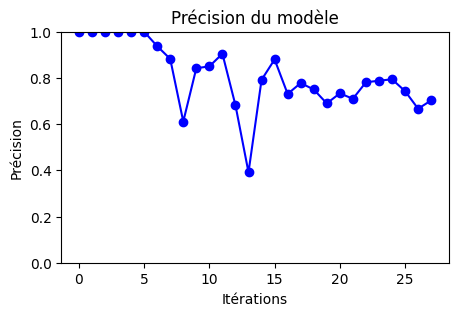

In [15]:
start_login_screen()

In [16]:
# import gc

# gc.collect()